# Bank Note Authentication using Machine Learning

## Acknowledgements
The data for this project was obtained from the UCI Machine Learning Repository  
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


In [60]:
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer

# Feature selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier

# classifiers / models
from sklearn.linear_model import LogisticRegression

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

### About the data

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

Link to data: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [61]:
# reading in raw data
raw = pd.read_csv('data/raw/BankNote_Authentication.csv')
raw

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Class = 0 means note is not authentic, class = 1 means note is authentic

In [22]:
# Splitting into train and test
train_df , test_df = train_test_split(raw, train_size = 0.75, random_state=2020, stratify=raw['class'])

In [23]:
test_df

,variance,skewness,curtosis,entropy,class
285,1.77470,-6.433400,8.150000,-0.89828,0
831,-0.39416,-0.020702,-0.066267,-0.44699,1
1238,-1.09410,2.307200,-2.523700,-1.44530,1
114,1.78190,6.917600,-1.274400,-1.57590,0
363,2.80500,0.577320,1.342400,1.21330,0
...,...,...,...,...,...
1304,-5.29430,-5.146300,10.333200,-1.11810,1
779,-1.81870,-9.036600,9.016200,-0.12243,1
1237,-0.88728,2.808000,-3.143200,-1.20350,1
631,1.89940,0.974620,4.226500,0.81377,0


## EDA

In [24]:
train_df.describe()

,variance,skewness,curtosis,entropy,class
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,0.400240,1.971326,1.369139,-1.234599,0.445092
std,2.849617,5.860764,4.285028,2.120853,0.497218
min,-7.042100,-13.659300,-5.215900,-8.548200,0.000000
25%,-1.821500,-1.690600,-1.557200,-2.466800,0.000000
50%,0.433900,2.294800,0.577220,-0.612510,0.000000
75%,2.796100,6.857600,3.089500,0.337910,1.000000
max,6.563300,12.730200,17.677200,2.449500,1.000000


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 251 to 404
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1029 non-null   float64
 1   skewness  1029 non-null   float64
 2   curtosis  1029 non-null   float64
 3   entropy   1029 non-null   float64
 4   class     1029 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 48.2 KB


In [26]:
train_df['class'].value_counts()

0    571
1    458
Name: class, dtype: int64

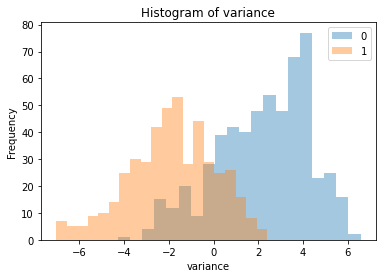

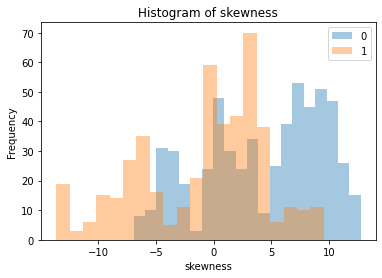

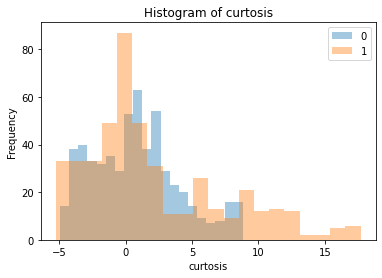

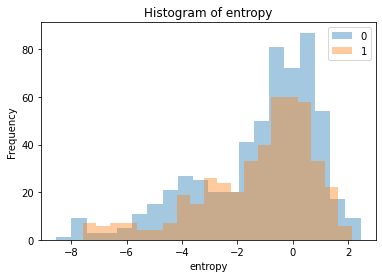

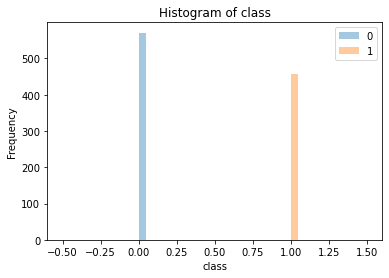

In [39]:
for i in list(train_df.columns):
    train_df.groupby("class")[i].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(i)
    plt.title("Histogram of " + i)
    plt.show()

## Creating X and y

In [41]:
X_train, y_train = train_df.drop(columns=['class']), train_df['class']
X_test, y_test = test_df.drop(columns=['class']), test_df['class']

## Dummy Classifier

In [51]:
# Helper code to compare classifier results

results = {}

def mean_std_cross_val_scores(model, X_train, y_train, 
                           scoring_metric = "accuracy"):
    """
    Returns mean and std of cross validation.  
    """
    scores = cross_validate(model, 
                            X_train, y_train, 
                            return_train_score=True,                                         
                            scoring=scoring_metric)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):  
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data = out_col, index = mean_scores.index)

In [53]:
dummy_clf = DummyClassifier()
results['Dummy Classifier'] = mean_std_cross_val_scores(dummy_clf, X_train, y_train, scoring_metric=['accuracy','f1'])
pd.DataFrame(results)

/Users/rahulkuriyedath/opt/miniconda3/envs/571/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


,Dummy Classifier
fit_time,0.001 (+/- 0.000)
score_time,0.001 (+/- 0.000)
test_accuracy,0.514 (+/- 0.018)
train_accuracy,0.517 (+/- 0.010)
test_f1,0.446 (+/- 0.032)
train_f1,0.461 (+/- 0.016)


## Comparing other classifiers

In [54]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=2),
    'SVC': SVC(random_state=2),
    'Random Forest' : RandomForestClassifier(random_state=2),
    'XGBoost' : XGBClassifier(random_state=2), 
    'LightGBM' : LGBMClassifier(random_state=2),
    'CatBoost' : CatBoostClassifier(verbose=0, random_state=2)
}

In [55]:
for k,v in classifiers.items():
    print(f'Training {k} based model')
    pipe = make_pipeline(StandardScaler(), v)
    results[k]=mean_std_cross_val_scores(pipe, X_train, y_train, scoring_metric=['accuracy','f1'])

Training Decision Tree based model
Training SVC based model
Training Random Forest based model
Training XGBoost based model
Training LightGBM based model
Training CatBoost based model


In [56]:
pd.DataFrame(results)

,Dummy Classifier,Decision Tree,SVC,Random Forest,XGBoost,LightGBM,CatBoost
fit_time,0.001 (+/- 0.000),0.006 (+/- 0.001),0.006 (+/- 0.001),0.146 (+/- 0.007),0.025 (+/- 0.010),0.054 (+/- 0.003),1.149 (+/- 0.039)
score_time,0.001 (+/- 0.000),0.003 (+/- 0.000),0.003 (+/- 0.001),0.011 (+/- 0.001),0.004 (+/- 0.001),0.004 (+/- 0.000),0.003 (+/- 0.000)
test_accuracy,0.514 (+/- 0.018),0.984 (+/- 0.011),1.000 (+/- 0.000),0.989 (+/- 0.007),0.991 (+/- 0.006),0.994 (+/- 0.004),0.997 (+/- 0.003)
train_accuracy,0.517 (+/- 0.010),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1,0.446 (+/- 0.032),0.983 (+/- 0.012),1.000 (+/- 0.000),0.988 (+/- 0.008),0.990 (+/- 0.007),0.993 (+/- 0.005),0.997 (+/- 0.003)
train_f1,0.461 (+/- 0.016),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


It looks like most of the models are performing really well on the training set (both train and cross validation accuracies and f1 are high)

## Test set evaluation

In [57]:
# trying out Catboost model
test_pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'), CatBoostClassifier(verbose=0, random_state=2))
test_pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7feea477cbd0>)])

In [58]:
test_pipe.score(X_test, y_test)

1.0

In [62]:
test_pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'), SVC())
test_pipe.fit(X_train, y_train)
test_pipe.score(X_test, y_test)

1.0